100%|█████████████████████████████████████████| 108M/108M [01:49<00:00, 453kB/s]
100%|████████████████████████████████████████| 108M/108M [01:49<00:00, 1.03MB/s]


ModuleNotFoundError: No module named 'torcheval'

In [13]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 514.2 kB/s eta 0:00:00a 0:00:01


In [1]:
from ast import Mod
from mimetypes import init
from pyexpat import model
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

import numpy as np
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from gc import callbacks
from lightgbm import early_stopping
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from xgboost import train
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet_pytorch
plt.rcParams['figure.dpi'] = 120

import pytorch_lightning as lg
from pytorch_lightning.loggers import TensorBoardLogger
import torchutils as tu
from efficientnet_pytorch import EfficientNet
from torcheval.metrics.functional import multiclass_f1_score


trnsfrmsv = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

trnsfrmst = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(),
    T.ToTensor()
    ]
)




class Model(nn.Module):
    def __init__(self,enet):
        super().__init__()
        self.model = enet
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model._dropout = nn.Dropout(0.0)
        self.model._fc = nn.Sequential(
            nn.Linear(self.model._fc.in_features, 1000),
            nn.LeakyReLU(),
            nn.Dropout(0.13),
            nn.Linear(1000, 4),
            
        )
        ##nn.init.kaiming_normal_(list(self.model._fc.parameters()), mode='fan_out', nonlinearity='leaky_relu')
    
    def forward(self, x):
        x = self.model(x)
        return x

class MyModel(lg.LightningModule):  
    def __init__(self):
        super().__init__()
        self.model = Model(EfficientNet.from_pretrained('efficientnet-b7'))
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        self.early_stopping = lg.callbacks.EarlyStopping(
            monitor='val_acc',  
            min_delta=0.004,      
            patience=7,         
            verbose=True,
            mode='max'           
        )
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        accuracy = (torch.argmax(y_pred, dim=1) == y).float().mean()
        f1loss=multiclass_f1_score(y_pred, y, num_classes=4)
        self.log('train_acc', accuracy)
        self.log('train_loss', loss)
        self.log('train_f1', f1loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        accuracy = (torch.argmax(y_pred, dim=1) == y).float().mean()
        f1loss= multiclass_f1_score(y_pred, y, num_classes=4)
        self.log('val_acc', accuracy)
        self.log('val_loss', loss)
        self.log('val_f1', f1loss)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer
    
    def on_epoch_end(self, epoch, logs=None):
        self.scheduler.step()
        if epoch % 10 == 0:
            self.early_stopping.step(logs['val_acc'])
            if self.early_stopping.early_stop:
                print("Early stopping")
                self.trainer.save_checkpoint("best_model.pt")
                self.trainer.save_checkpoint("last_model.pt")
                return


model=torch.load("bruhmodel62.pt",map_location=torch.device('cpu'))

train_dataset = torchvision.datasets.ImageFolder ('dataset2-master/dataset2-master/images/TRAIN', transform=trnsfrmst)
valid_dataset = torchvision.datasets.ImageFolder ('dataset2-master/dataset2-master/images/TEST', transform=trnsfrmsv)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True,num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True,num_workers=3)




In [3]:
from sklearn.metrics import confusion_matrix

# Получение предсказаний модели
y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for images, labels in valid_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted.numpy())

# Построение confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Отрисовка confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(valid_dataset.classes))
plt.xticks(tick_marks, valid_dataset.classes, rotation=45)
plt.yticks(tick_marks, valid_dataset.classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

KeyboardInterrupt: 

In [ ]:

#m=EfficientNet.from_pretrained('efficientnet-b7')
from torchvision.models import resnet18, ResNet18_Weights
m=resnet18(weights=ResNet18_Weights.DEFAULT)
tu.get_model_summary(m, torch.randn(1, 3, 224, 224, device='cpu'))

In [ ]:
m=EfficientNet.from_pretrained('efficientnet-b7')
tu.get_model_summary(m, torch.randn(1, 3, 224, 224, device='cpu'))

In [38]:
len(train_dataset)

2487

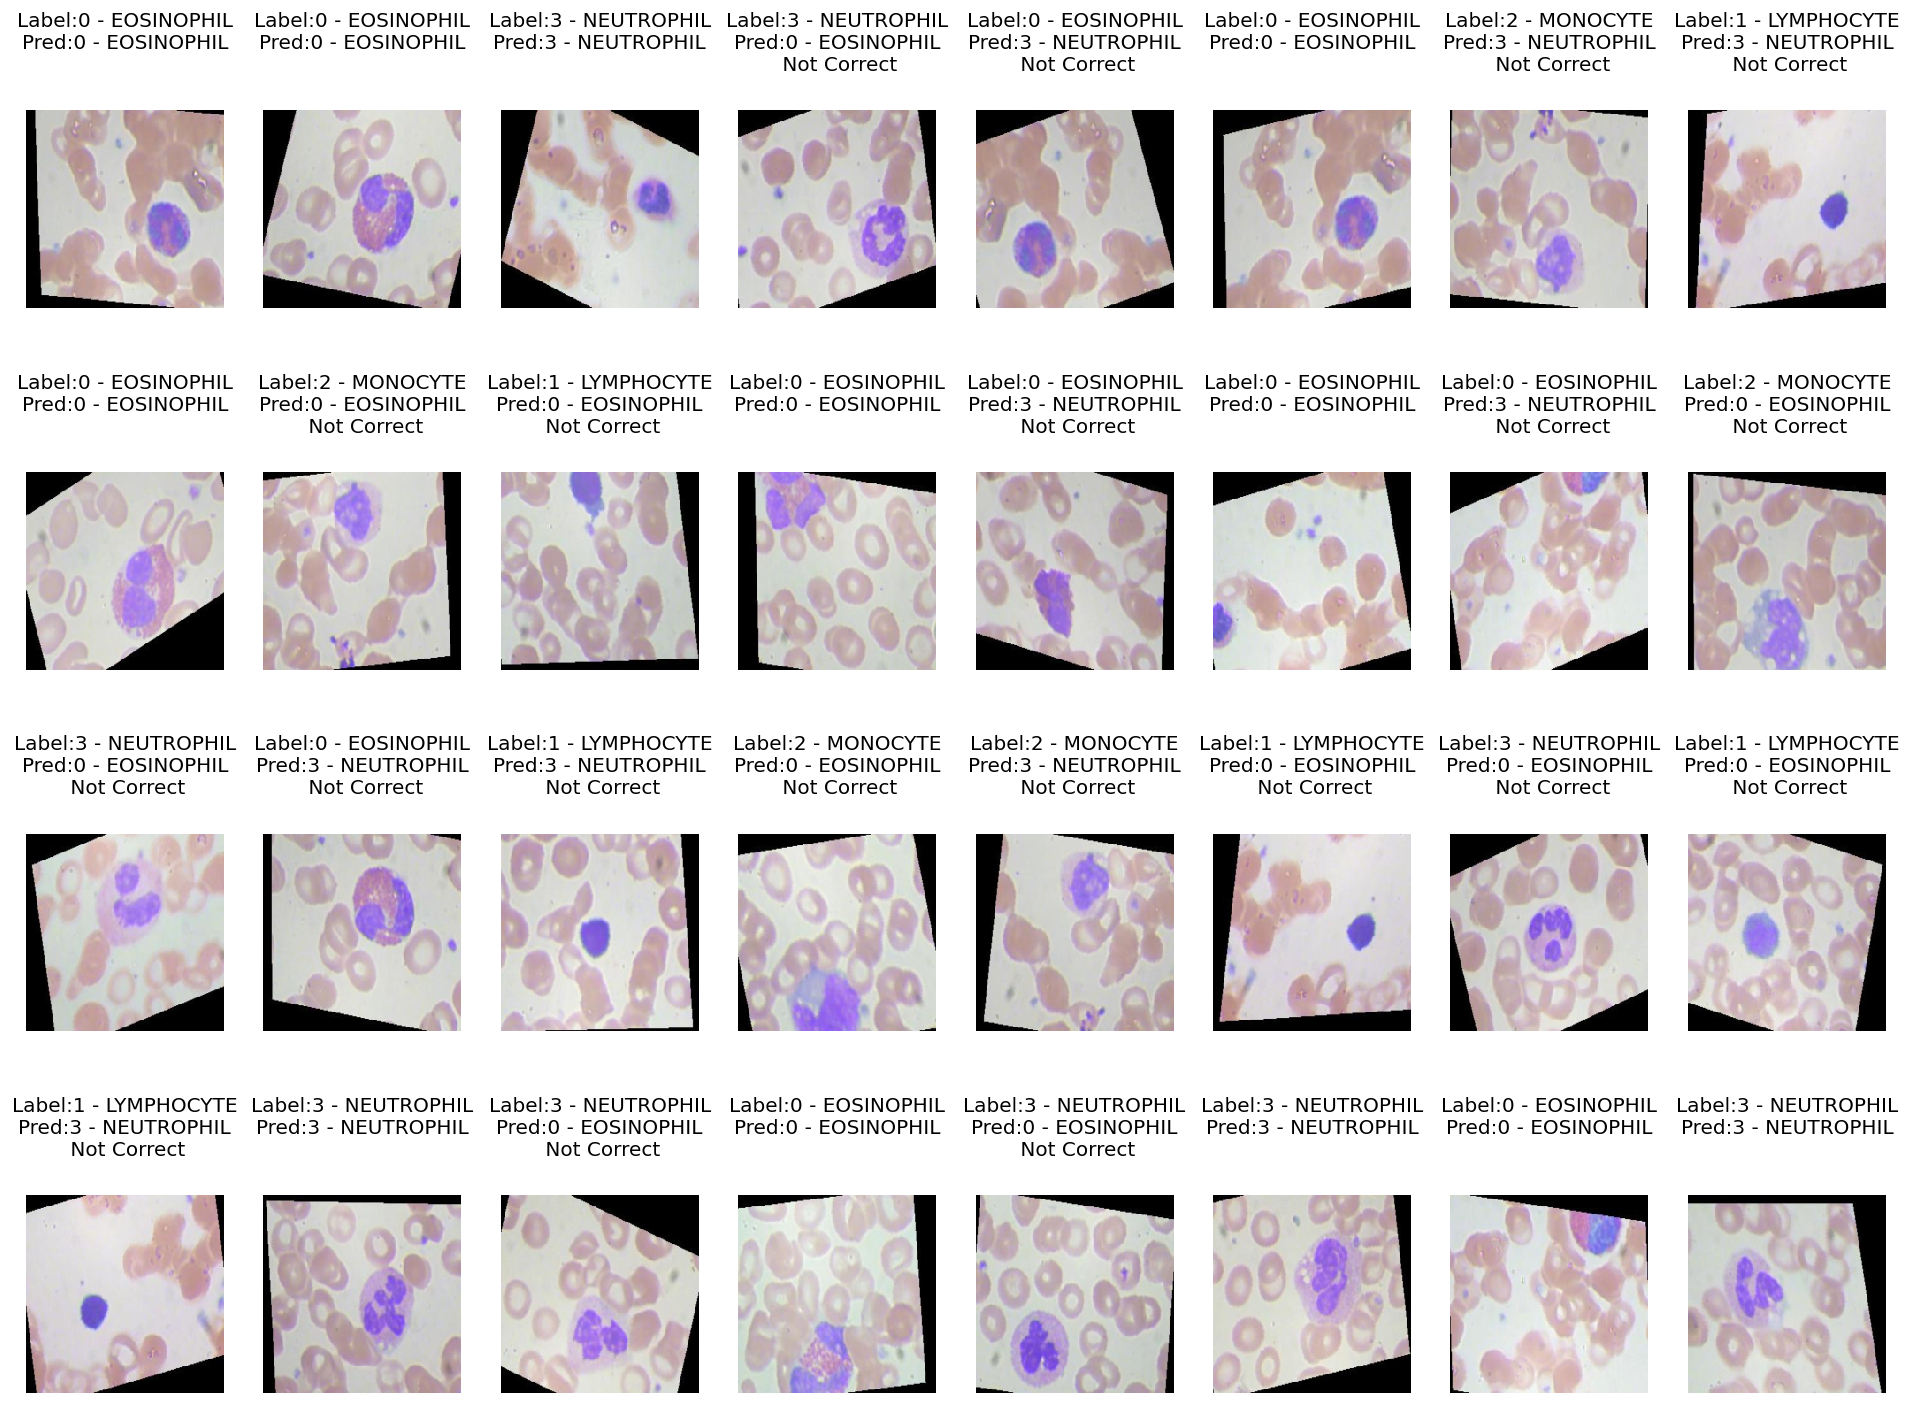

In [7]:


def getplots(model, train_loader):
    def get_batch_from_loader(loader):
        batch, labels = next(iter(loader))
        return batch, labels

    fig, ax = plt.subplots(4, 8, figsize=(20, 15))
    ax = ax.flatten()
    batch, labels = get_batch_from_loader(train_loader)
    batch=batch[:4*8]

    for i, plot in enumerate(ax):
        pred = model(batch[i].unsqueeze(0)).argmax().item()
        plot.set_title(f'Label:{labels[i]} - {train_loader.dataset.classes[labels[i]]}\nPred:{pred} - {valid_loader.dataset.classes[pred]}\n {'' if pred == labels[i] else "Not Correct"}')
        image = torch.permute(batch[i], (1, 2, 0)).numpy()
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())
        plot.matshow(image)
        plot.axis('off')

getplots(model, valid_loader)


In [4]:
!tensorboard --logdir /kaggle/working/logs

2024-03-29 15:22:19.535349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 15:22:23.952323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
/kaggle/working/saved_models/epoch-epoch=03-val_acc=0.68.ckpt


from ast import Mod
from mimetypes import init
from pyexpat import model
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

import numpy as np
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from gc import callbacks
from lightgbm import early_stopping
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from xgboost import train
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet_pytorch
plt.rcParams['figure.dpi'] = 120

import pytorch_lightning as lg
from pytorch_lightning.loggers import TensorBoardLogger
import torchutils as tu
from efficientnet_pytorch import EfficientNet
from torcheval.metrics.functional import multiclass_f1_score


trnsfrmsv = T.Compose([
    #T.Resize((224, 224)),
    T.ToTensor()
    ]
)

trnsfrmst = T.Compose([
    #T.Resize((224, 224)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(),
    T.ToTensor()
    ]
)


train_dataset = torchvision.datasets.ImageFolder ('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN', transform=trnsfrmst)
valid_dataset = torchvision.datasets.ImageFolder ('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST', transform=trnsfrmsv)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True,num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True,num_workers=3)



class Model(nn.Module):
    def __init__(self,enet):
        super().__init__()
        self.model = enet
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model._dropout = nn.Dropout(0)
        self.model._fc = nn.Sequential(
            nn.Linear(self.model._fc.in_features, 4)
        )
        ##nn.init.kaiming_normal_(list(self.model._fc.parameters()), mode='fan_out', nonlinearity='leaky_relu')
    
    def forward(self, x):
        x = self.model(x)
        return x

class MyModel(lg.LightningModule):  
    def __init__(self):
        super().__init__()
        self.model = Model(EfficientNet.from_pretrained('efficientnet-b7'))
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        self.early_stopping = lg.callbacks.EarlyStopping(
            monitor='val_acc',  
            min_delta=0.004,      
            patience=7,         
            verbose=True,
            mode='max'           
        )
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        accuracy = (torch.argmax(y_pred, dim=1) == y).float().mean()
        f1loss=multiclass_f1_score(y_pred, y, num_classes=4)
        self.log('train_acc', accuracy)
        self.log('train_loss', loss)
        self.log('train_f1', f1loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        accuracy = (torch.argmax(y_pred, dim=1) == y).float().mean()
        f1loss= multiclass_f1_score(y_pred, y, num_classes=4)
        self.log('val_acc', accuracy)
        self.log('val_loss', loss)
        self.log('val_f1', f1loss)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer
    
    def on_epoch_end(self, epoch, logs=None):
        self.scheduler.step()
        if epoch % 10 == 0:
            self.early_stopping.step(logs['val_acc'])
            if self.early_stopping.early_stop:
                print("Early stopping")
                self.trainer.save_checkpoint("best_model.pt")
                self.trainer.save_checkpoint("last_model.pt")
                return

checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',  # Мониторим метрику, которая будет использоваться для сохранения лучших моделей
    dirpath='/kaggle/working/saved_models/',  # Папка для сохранения моделей
    filename='epoch-{epoch:02d}-{val_acc:.2f}',  # Имя файла модели
    save_top_k=1,  # Сохранять только одну лучшую модель
    mode='max',  # Максимизация метрики
)

model = MyModel()
# tu.get_model_summary(model, torch.randn(1, 3, 224, 224, device='cpu'))
    
logger = TensorBoardLogger("logs", name="catdogclassifier")
trainer = lg.Trainer(max_epochs=100, logger=logger,callbacks=[model.early_stopping, checkpoint_callback])
trainer.fit(model, train_loader, valid_loader)
torch.save(model, 'model.pt')
